In [1]:
import numpy as np
from shapely.geometry import LineString, MultiLineString
import matplotlib.pyplot as plt
import geopandas as gpd
import momepy
import networkx as nx
import numpy as np
import os 
from tqdm import tqdm

In [ ]:
def merged_G_angle(G,tresh):
    H = G.copy() 
    # for i in range(10):
    filtered_H = H.copy()
    edges_to_remove = [(u, v) for u, v, a in H.edges(data=True) if (a['angle'] > tresh)]
    filtered_H.remove_edges_from(edges_to_remove)
    S = [H.subgraph(c).copy() for c in nx.connected_components(filtered_H)]

    mapping = {}
    for s in S: # components
        node_list = list(s.nodes())
        mean_node = tuple(np.mean(np.array(node_list), axis=0))
        mapping.update({n: mean_node for n in node_list})


    H=nx.relabel_nodes(H, mapping)
    return H, mapping

In [3]:
def base(L):
    """Create base grid lines within a square of side length L."""
    lines = [
        [(0, L/3), (L, L/3)],
        [(0, L*2/3), (L, L*2/3)],
        [(L/3, 0), (L/3, L)],
        [(L*2/3, 0), (L*2/3, L)]
    ]
    return [LineString(points) for points in lines]

def fractal_pattern(L, depth):
    """Generate a fractal pattern by recursively placing the base pattern in four corners."""
    if depth == 0:
        return base(L)
    
    # Generate smaller fractal patterns in each of the four corners
    smaller_L = L / 3
    patterns = []
    
    # Positions for the four corners (bottom-left, bottom-right, top-left, top-right)
    shifts = [(0, 0), (2 * smaller_L, 0), (0, 2 * smaller_L), (2 * smaller_L, 2 * smaller_L)]
    
    for dx, dy in shifts:
        # Recursively create a fractal pattern in each corner
        sub_patterns = fractal_pattern(smaller_L, depth - 1)
        for line in sub_patterns:
            # Shift each line in the sub-pattern by the corner's offset
            shifted_coords = np.array(line.coords) + np.array([dx, dy])
            patterns.append(LineString(shifted_coords))
    
    # Add the current level's base pattern in the center
    patterns.extend(base(L))
    return patterns

In [10]:
lines = fractal_pattern(1, 3)

In [11]:
carpet = gpd.GeoDataFrame(geometry=lines)
carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.unary_union), crs=carpet.crs).explode()
carpet = gpd.GeoDataFrame(geometry=carpet)
G=momepy.gdf_to_nx(carpet,approach='dual',angles=True, multigraph=False)

/tmp/ipykernel_373405/1392757743.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.unary_union), crs=carpet.crs).explode()
/home/lpsha/.conda/envs/py39/lib/python3.9/site-packages/momepy/utils.py:99: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  sw = libpysal.weights.Queen.from_dataframe(gdf_network, silence_warnings=True)


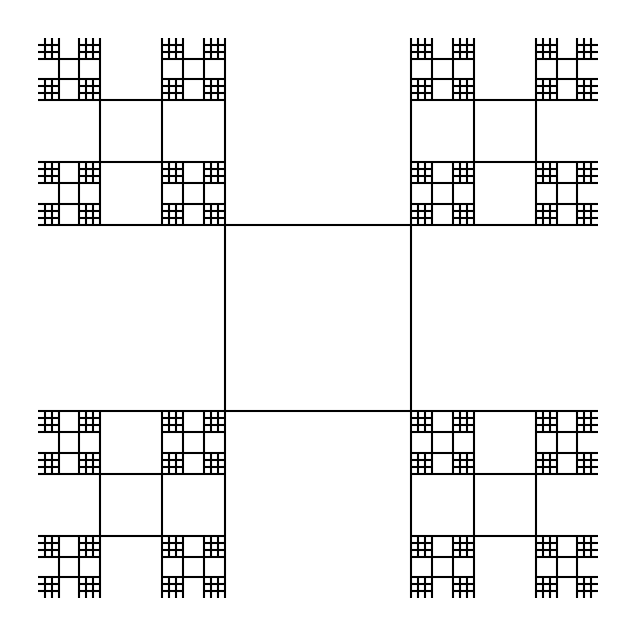

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
carpet.plot(color='k',ax=ax)
# plt.xscale('log')
# plt.yscale('log')
plt.axis('off')
plt.show()

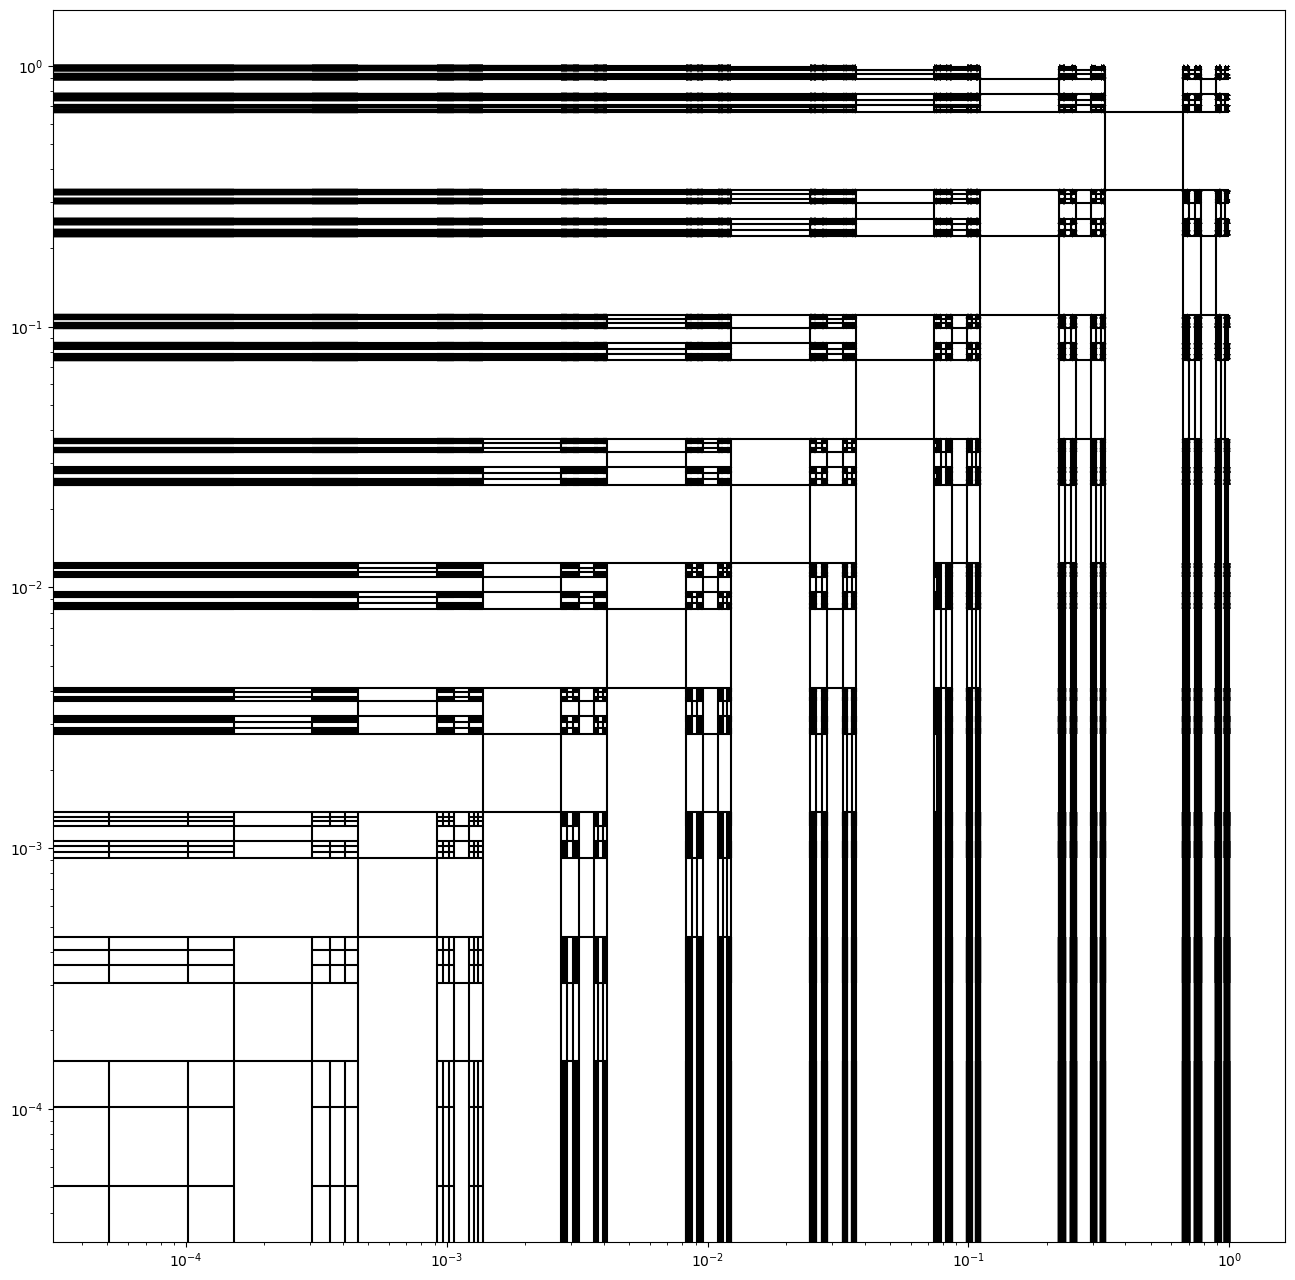

In [123]:
fig, ax = plt.subplots(figsize=(16,16))
carpet.plot(color='k',ax=ax)
plt.xscale('log')
plt.yscale('log')
plt.show()

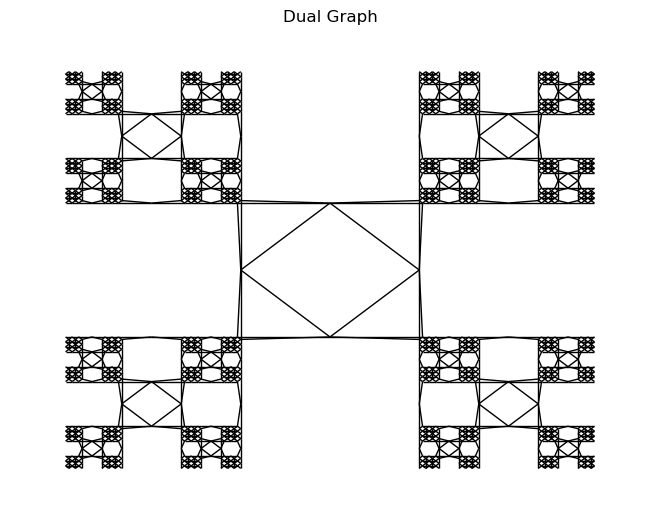

In [ ]:
nx.draw(G,pos={n: [n[0], n[1]] for n in list(G.nodes)},node_size=0)
plt.title('Dual Graph')
plt.show()

In [14]:
H, _ = merged_G_angle(G,10)
H.remove_edges_from(nx.selfloop_edges(H))

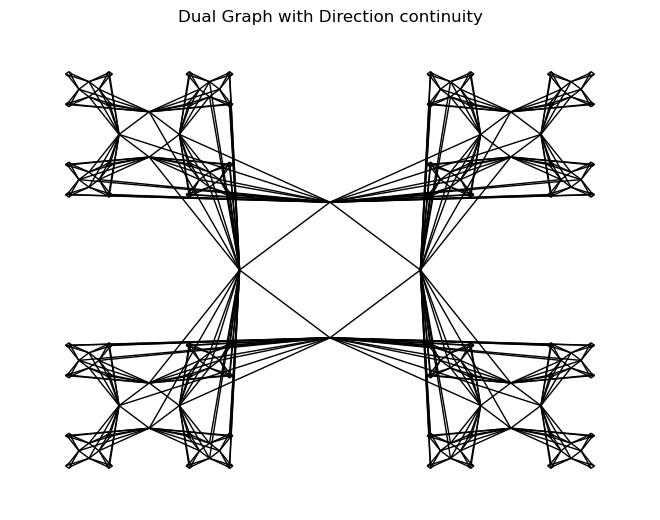

In [22]:
nx.draw(H,pos={n: [n[0], n[1]] for n in list(H.nodes)},node_size=0)
plt.title('Dual Graph with Direction continuity')
plt.show()

In [16]:
degree_sequence = np.array([d for n, d in H.degree()])

In [17]:
path = '/work/lpsha/data/regime/'
cities = os.listdir(path)

real_degree_sequence = np.array([])
for city in tqdm(cities):
        real_degree_sequence=np.append(real_degree_sequence, np.loadtxt(path+city))

100%|████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 14.33it/s]


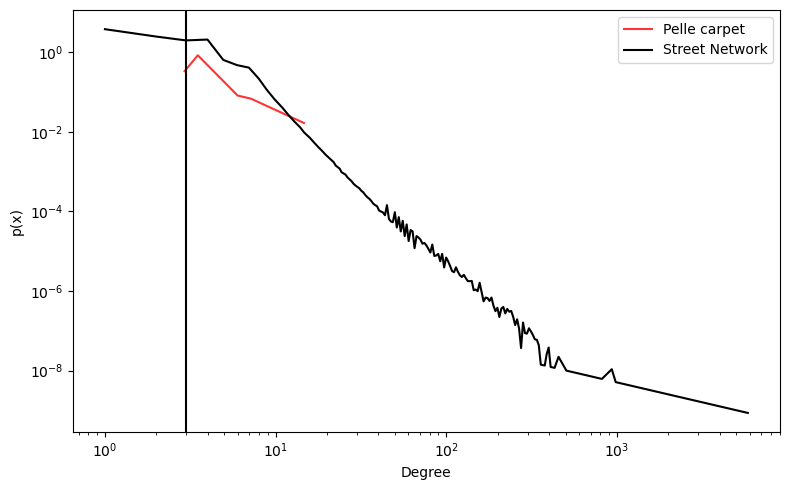

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
degree = degree_sequence[degree_sequence!=0]
y, x = np.histogram(degree,bins=np.logspace(0,np.log10(degree.max()),20),density=True)
x = x[:-1]
x_nn = x[y!=0]
y_nn = y[y!=0]
ax.plot(x_nn,y_nn,alpha=0.8,zorder=2,color='red',label='Pelle carpet')

###################

degree = real_degree_sequence[real_degree_sequence!=0]
y, x = np.histogram(degree,bins=np.logspace(0,np.log10(degree.max()),len(np.unique(degree))),density=True)
x = x[:-1]
x_nn = x[y!=0]
y_nn = y[y!=0]
ax.plot(x_nn,y_nn,alpha=1,zorder=2,color='k',label='Street Network')

##################

ax.set_ylabel('p(x)')
ax.set_xlabel('Degree')
ax.set_xscale('log')
ax.set_yscale('log')
plt.axvline(3,color='k')
plt.legend()
plt.tight_layout()
plt.show()

# Function of $t$

- all: D = T
- chess pattern: D = T/2  (only odd number)
- cross D=T *2-1 (for odd) D=T *2 for even
- corners: D = 4

In [6]:
def base_t(L, t):
    """Create base grid lines within a square of side length L."""
    N = t - 1
    xy = np.linspace(1, N, N) * (L / t)
    horizontal_lines = [LineString([(0, y), (L, y)]) for y in xy]
    vertical_lines = [LineString([(x, 0), (x, L)]) for x in xy]
    return horizontal_lines + vertical_lines

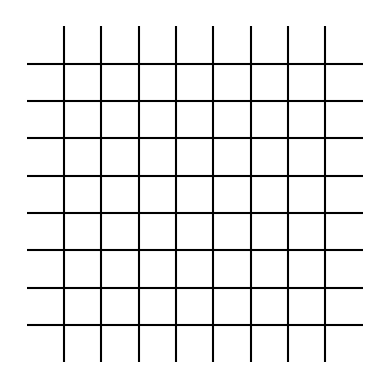

In [7]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=base_t(1, 9)).plot(color='k',ax=ax)
plt.axis('off')
plt.show()

In [8]:
def fractal_pattern_corner(L, depth,t):
    """Generate a fractal pattern by recursively placing the base pattern in four corners."""
    if depth == 0:
        return base_t(L,t)
    
    # Generate smaller fractal patterns in each of the four corners
    smaller_L = L / t
    patterns = []
    
    # Positions for the four corners (bottom-left, bottom-right, top-left, top-right)
    shifts = [(0, 0), (2 * smaller_L, 0), (0, 2 * smaller_L), (2 * smaller_L, 2 * smaller_L)]
    
    for dx, dy in shifts:
        # Recursively create a fractal pattern in each corner
        sub_patterns = fractal_pattern_corner(smaller_L, depth - 1,t)
        for line in sub_patterns:
            # Shift each line in the sub-pattern by the corner's offset
            shifted_coords = np.array(line.coords) + np.array([dx, dy])
            patterns.append(LineString(shifted_coords))
    
    # Add the current level's base pattern in the center
    patterns.extend(base_t(L,t))
    return patterns

In [16]:
def fractal_pattern_chess(L, depth,t):
    """Generate a fractal pattern by recursively placing the base pattern in four corners."""
    if depth == 0:
        return base_t(L,t)
    
    # Generate smaller fractal patterns in each of the four corners
    smaller_L = L / t
    patterns = []
    
    # Positions for the four corners (bottom-left, bottom-right, top-left, top-right)
    shifts = [(0, 0), (2 * smaller_L, 0), (0, 2 * smaller_L), (2 * smaller_L, 2 * smaller_L),(smaller_L,smaller_L)]
    
    for dx, dy in shifts:
        # Recursively create a fractal pattern in each corner
        sub_patterns = fractal_pattern_corner(smaller_L, depth - 1,t)
        for line in sub_patterns:
            # Shift each line in the sub-pattern by the corner's offset
            shifted_coords = np.array(line.coords) + np.array([dx, dy])
            patterns.append(LineString(shifted_coords))
    
    # Add the current level's base pattern in the center
    patterns.extend(base_t(L,t))
    return patterns

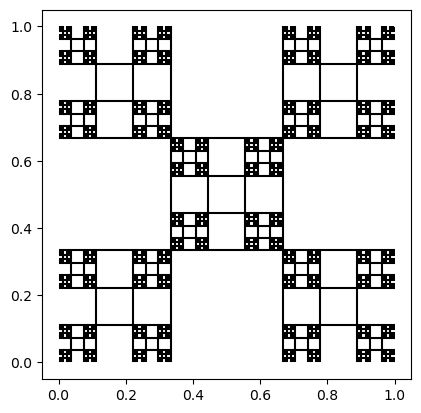

In [29]:
fractal = fractal_pattern_chess(1, 4,t=3)

fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=fractal).plot(color='k',ax=ax)
# plt.axis('off')
plt.show()

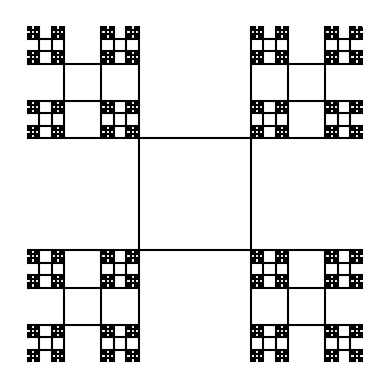

In [28]:
fractal = fractal_pattern_corner(1, 4,t=3)

fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=fractal).plot(color='k',ax=ax)
plt.axis('off')
plt.show()

In [206]:
carpet = gpd.GeoDataFrame(geometry=fractal)
carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.unary_union), crs=carpet.crs).explode()
carpet = gpd.GeoDataFrame(geometry=carpet)
G=momepy.gdf_to_nx(carpet,approach='dual',angles=True, multigraph=False)

/tmp/ipykernel_373405/3266587358.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.unary_union), crs=carpet.crs).explode()
/home/lpsha/.conda/envs/py39/lib/python3.9/site-packages/momepy/utils.py:99: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  sw = libpysal.weights.Queen.from_dataframe(gdf_network, silence_warnings=True)


In [207]:
H, _ = merged_G_angle(G,10)
H.remove_edges_from(nx.selfloop_edges(H))

In [208]:
degree_sequence = np.array([d for n, d in H.degree()])

In [211]:
np.min(degree_sequence)

8

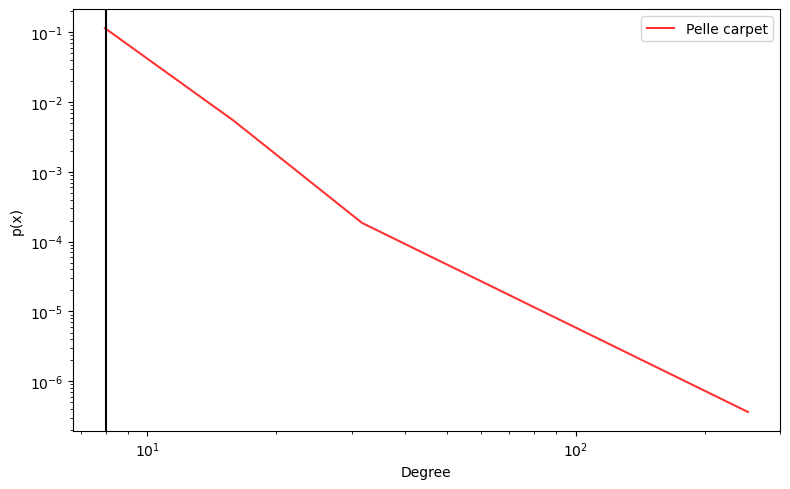

In [210]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
degree = degree_sequence[degree_sequence!=0]
y, x = np.histogram(degree,bins=np.logspace(0,np.log10(degree.max()),10),density=True)
x = x[:-1]
x_nn = x[y!=0]
y_nn = y[y!=0]
ax.plot(x_nn,y_nn,alpha=0.8,zorder=2,color='red',label='Pelle carpet')

ax.set_ylabel('p(x)')
ax.set_xlabel('Degree')
ax.set_xscale('log')
ax.set_yscale('log')
plt.axvline(8,color='k')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_373405/1953831722.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.unary_union), crs=carpet.crs).explode()
/home/lpsha/.conda/envs/py39/lib/python3.9/site-packages/momepy/utils.py:99: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  sw = libpysal.weights.Queen.from_dataframe(gdf_network, silence_warnings=True)
/tmp/ipykernel_373405/1953831722.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet

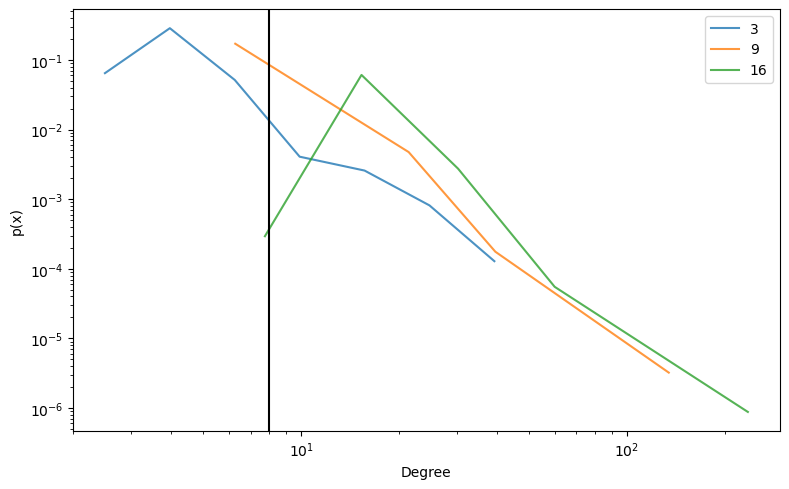

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

for dd in [3,9,16]:
    fractal = fractal_pattern_corner(1, 4,t=dd)
    carpet = gpd.GeoDataFrame(geometry=fractal)
    carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.unary_union), crs=carpet.crs).explode()
    carpet = gpd.GeoDataFrame(geometry=carpet)
    G=momepy.gdf_to_nx(carpet,approach='dual',angles=True, multigraph=False)
    H, _ = merged_G_angle(G,10)
    H.remove_edges_from(nx.selfloop_edges(H))
    degree_sequence = np.array([d for n, d in H.degree()])


    degree = degree_sequence[degree_sequence!=0]
    y, x = np.histogram(degree,bins=np.logspace(0,np.log10(degree.max()),10),density=True)
    x = x[:-1]
    x_nn = x[y!=0]
    y_nn = y[y!=0]
    ax.plot(x_nn,y_nn,alpha=0.8,zorder=2,label=str(dd))

ax.set_ylabel('p(x)')
ax.set_xlabel('Degree')
ax.set_xscale('log')
ax.set_yscale('log')
plt.axvline(8,color='k')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_383536/973607327.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.unary_union), crs=carpet.crs).explode()
/home/lpsha/.conda/envs/py39/lib/python3.9/site-packages/momepy/utils.py:99: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  sw = libpysal.weights.Queen.from_dataframe(gdf_network, silence_warnings=True)
/tmp/ipykernel_383536/973607327.py:24: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.

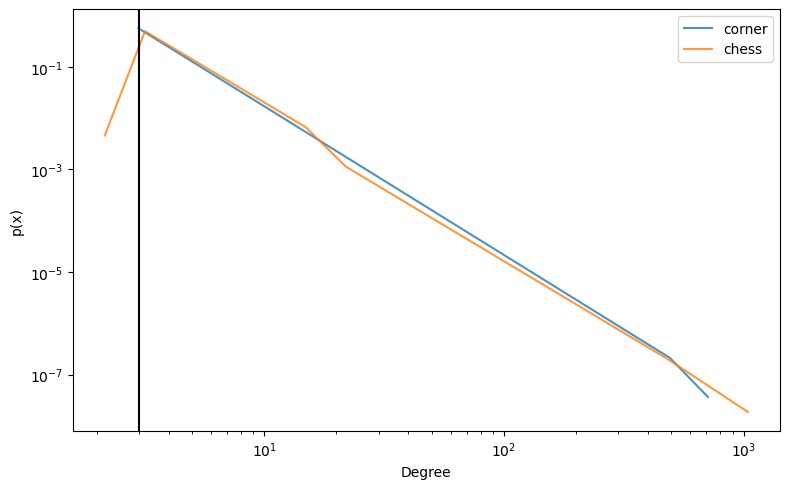

In [35]:
fig, ax = plt.subplots(figsize=(8,5))

depth = 8

fractal = fractal_pattern_corner(1, depth,t=3)
carpet = gpd.GeoDataFrame(geometry=fractal)
carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.unary_union), crs=carpet.crs).explode()
carpet = gpd.GeoDataFrame(geometry=carpet)
G=momepy.gdf_to_nx(carpet,approach='dual',angles=True, multigraph=False)
H, _ = merged_G_angle(G,10)
H.remove_edges_from(nx.selfloop_edges(H))
degree_sequence = np.array([d for n, d in H.degree()])
degree = degree_sequence[degree_sequence!=0]
y, x = np.histogram(degree,bins=np.logspace(0,np.log10(degree.max()),20),density=True)
x = x[:-1]
x_nn = x[y!=0]
y_nn = y[y!=0]
ax.plot(x_nn,y_nn,alpha=0.8,zorder=2,label='corner')



fractal = fractal_pattern_chess(1, depth ,t=3)
carpet = gpd.GeoDataFrame(geometry=fractal)
carpet = gpd.GeoSeries(carpet.unary_union.intersection(carpet.unary_union), crs=carpet.crs).explode()
carpet = gpd.GeoDataFrame(geometry=carpet)
G=momepy.gdf_to_nx(carpet,approach='dual',angles=True, multigraph=False)
H, _ = merged_G_angle(G,10)
H.remove_edges_from(nx.selfloop_edges(H))
degree_sequence = np.array([d for n, d in H.degree()])
degree = degree_sequence[degree_sequence!=0]
y, x = np.histogram(degree,bins=np.logspace(0,np.log10(degree.max()),20),density=True)
x = x[:-1]
x_nn = x[y!=0]
y_nn = y[y!=0]
ax.plot(x_nn,y_nn,alpha=0.8,zorder=2,label='chess')

ax.set_ylabel('p(x)')
ax.set_xlabel('Degree')
ax.set_xscale('log')
ax.set_yscale('log')
plt.axvline(3,color='k')
plt.legend()
plt.tight_layout()
plt.show()